In [26]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import re

from sklearn.preprocessing import OneHotEncoder

# Problem 5. Exploratory data analysis 
This step may, or may not, happen in unison with the previous one. Your goal is to understand the data distributions, relationships, useful features, maybe create visualizations and inform your data cleaning process.

In [19]:
asthma_vis = pd.read_csv("../data/asthma_disease_data_vis.csv")
asthma_an = pd.read_csv("../data/asthma_disease_data_analysis.csv")

In [20]:
asthma_vis.columns

Index(['patient_id', 'age', 'gender', 'ethnicity', 'education_level', 'bmi',
       'smoking', 'physical_activity', 'diet_quality', 'sleep_quality',
       'pollution_exposure', 'pollen_exposure', 'dust_exposure', 'pet_allergy',
       'family_history_asthma', 'history_of_allergies', 'eczema', 'hay_fever',
       'gastroesophageal_reflux', 'lung_function_fev1', 'lung_function_fvc',
       'wheezing', 'shortness_of_breath', 'chest_tightness', 'coughing',
       'nighttime_symptoms', 'exercise_induced', 'diagnosis'],
      dtype='object')

Recall data types

In [21]:
asthma_vis.dtypes

patient_id                   int64
age                          int64
gender                      object
ethnicity                   object
education_level             object
bmi                        float64
smoking                     object
physical_activity          float64
diet_quality               float64
sleep_quality              float64
pollution_exposure         float64
pollen_exposure            float64
dust_exposure              float64
pet_allergy                 object
family_history_asthma       object
history_of_allergies        object
eczema                      object
hay_fever                   object
gastroesophageal_reflux     object
lung_function_fev1         float64
lung_function_fvc          float64
wheezing                    object
shortness_of_breath         object
chest_tightness             object
coughing                    object
nighttime_symptoms          object
exercise_induced            object
diagnosis                    int64
dtype: object

## Univariate visualization: Visualize all variables

A function drawing a bar chart if the variable is categorical or a histogram if the variable is numeric. 

In [22]:
def plot_all(df, max_unique=20):
    """
    Loops through all columns in df and plots bar charts 
    for those that are categorical (object, category, or numeric with few uniques).
    """
    for col in df.columns:
        series = df[col]
        dtype = series.dtype
        
        # Case 1: categorical dtype
        if isinstance(dtype, pd.CategoricalDtype) or dtype == "object":
            counts = series.value_counts()
            counts.plot(kind="bar")
            plt.title(f"Bar chart of {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.show()
        
        # Case 2: numeric but with few unique values (treat as categorical)
        elif pd.api.types.is_numeric_dtype(dtype) and series.nunique() <= max_unique:
            counts = series.value_counts().sort_index()
            counts.plot(kind="bar")
            plt.title(f"Bar chart of {col} (numeric categorical)")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.show()

        else: 
            plt.hist(series, bins = 10)
            plt.title(f"Histogram of {col} (numeric)")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.show()            


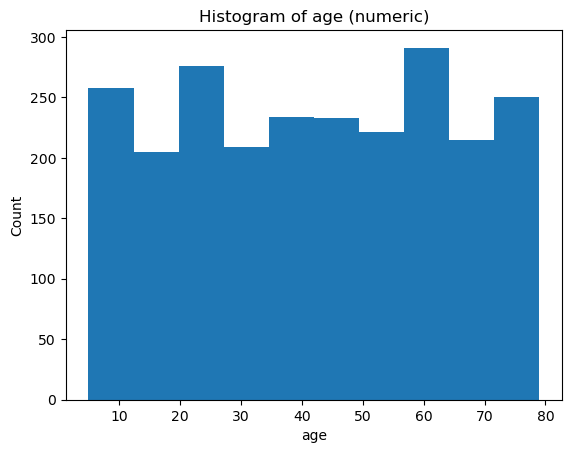

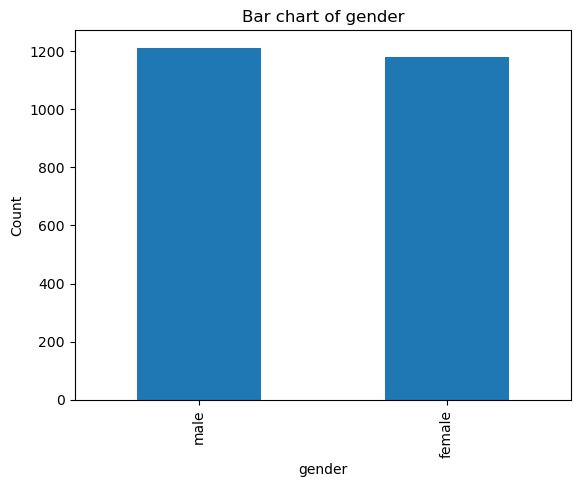

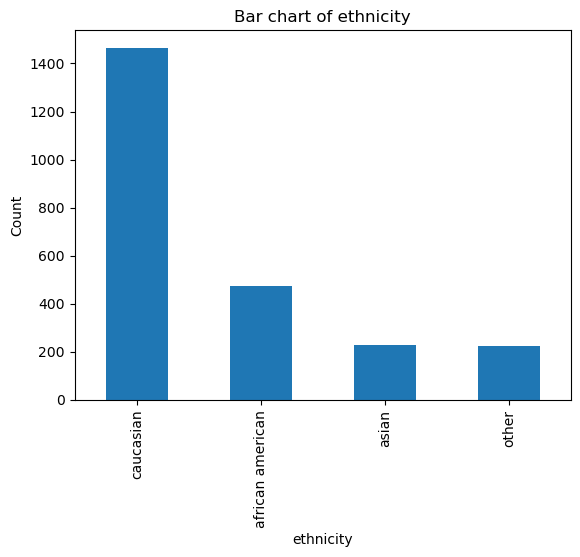

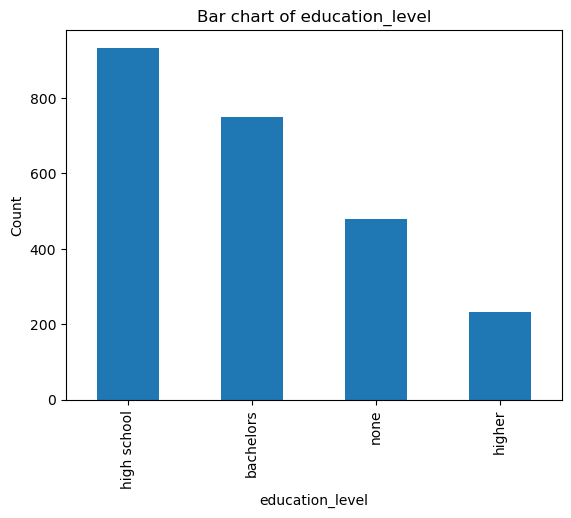

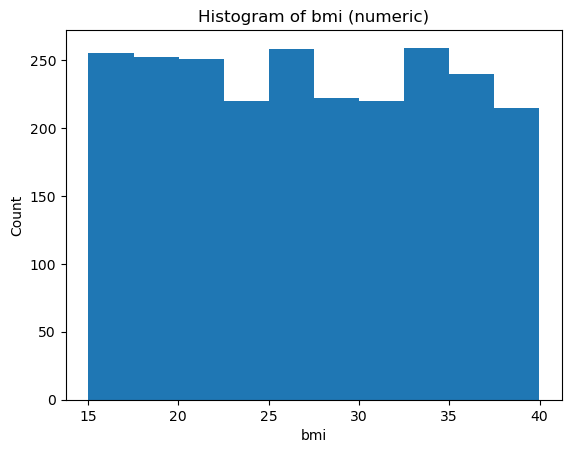

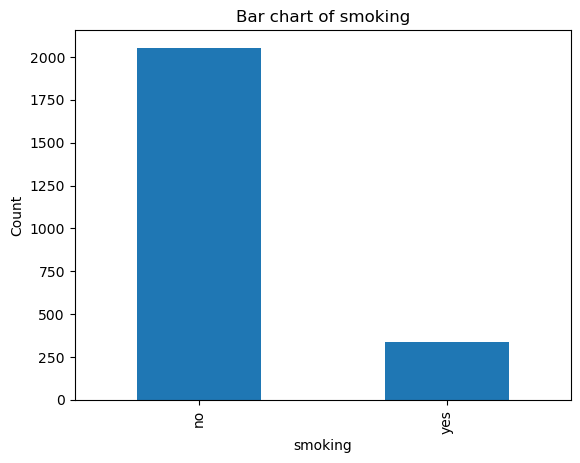

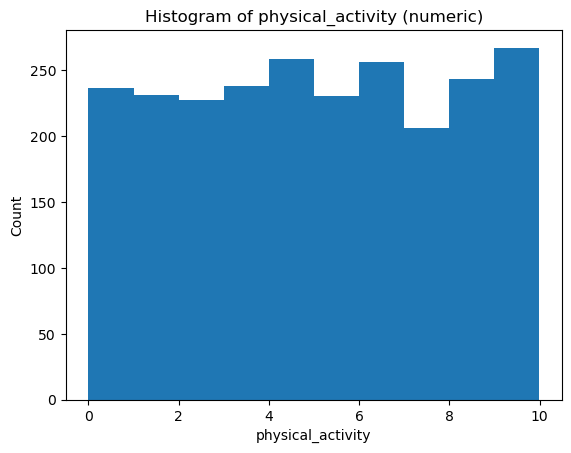

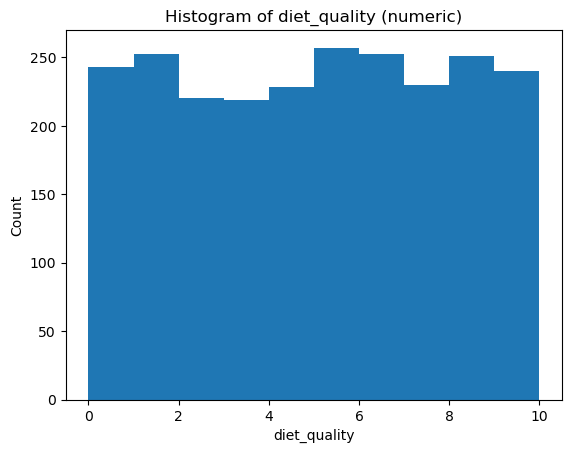

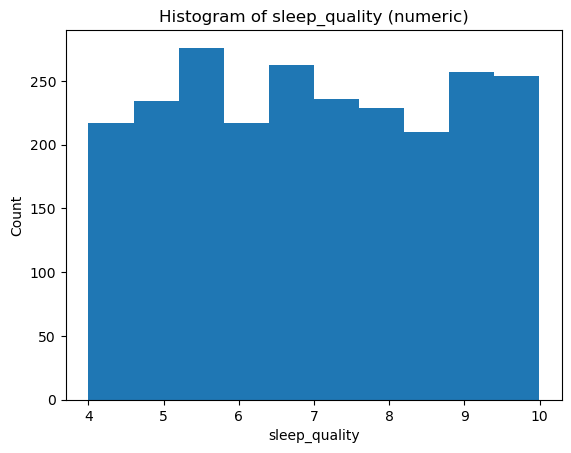

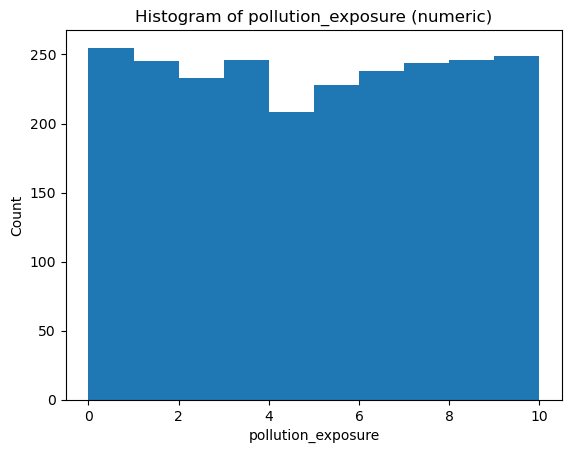

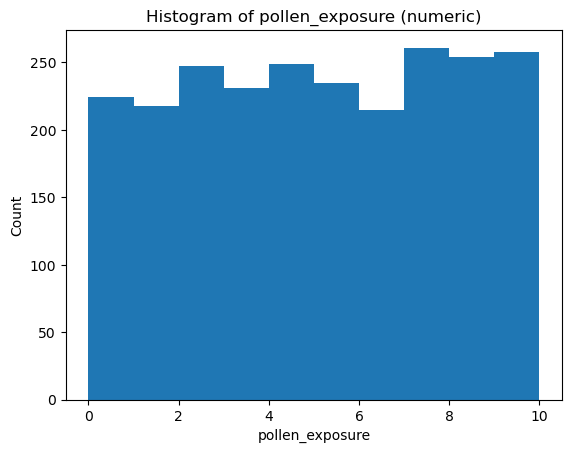

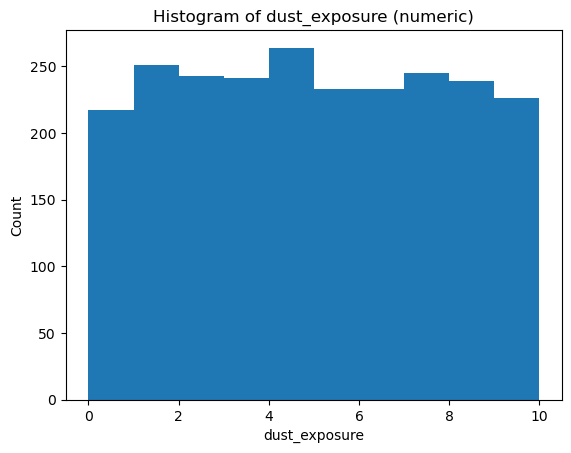

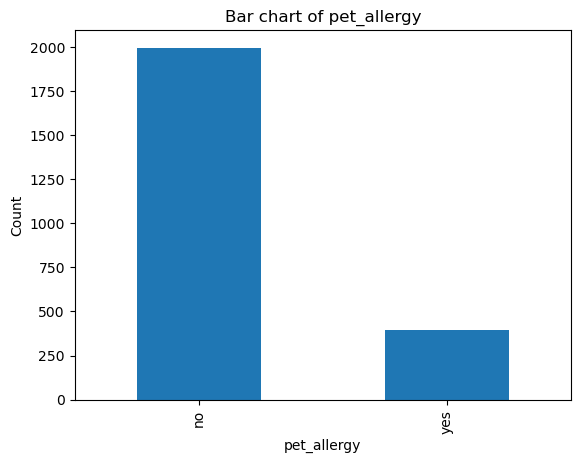

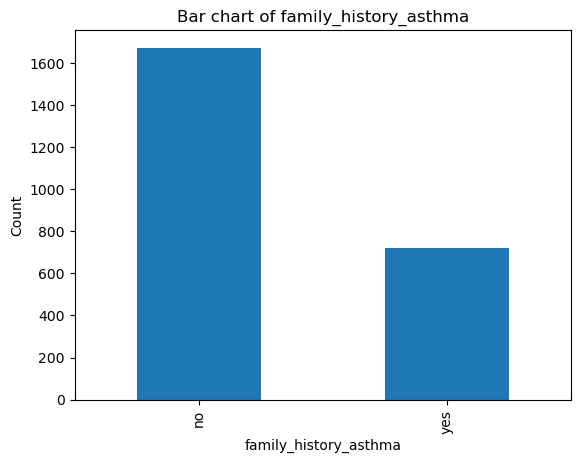

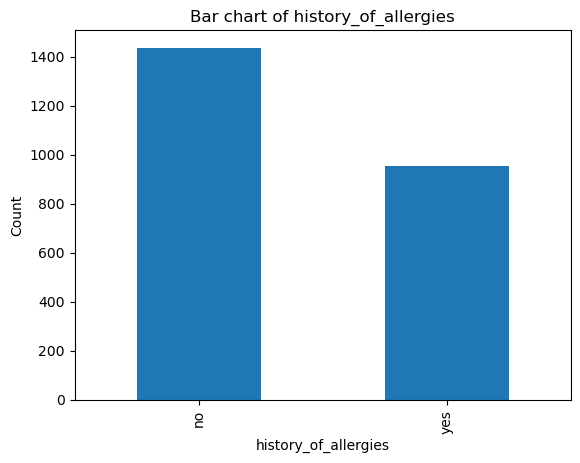

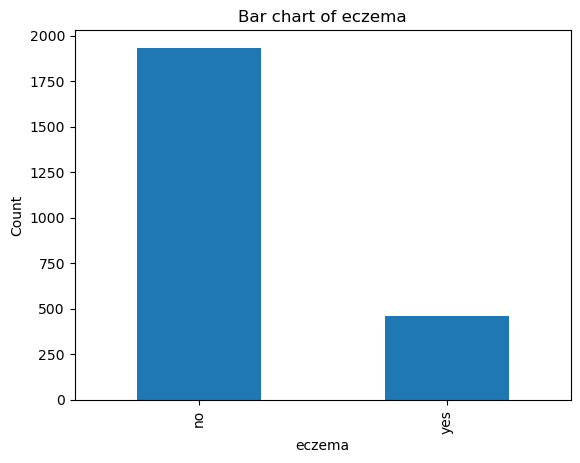

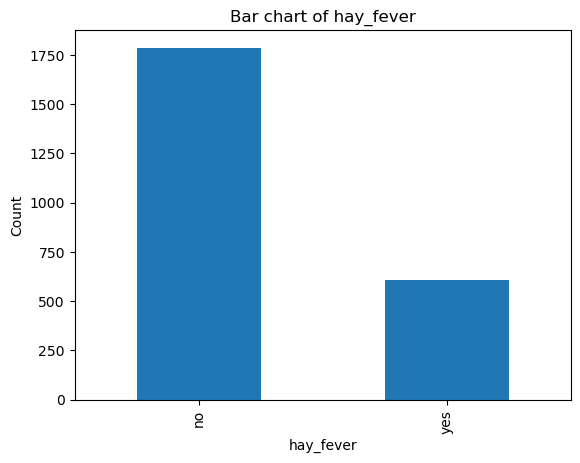

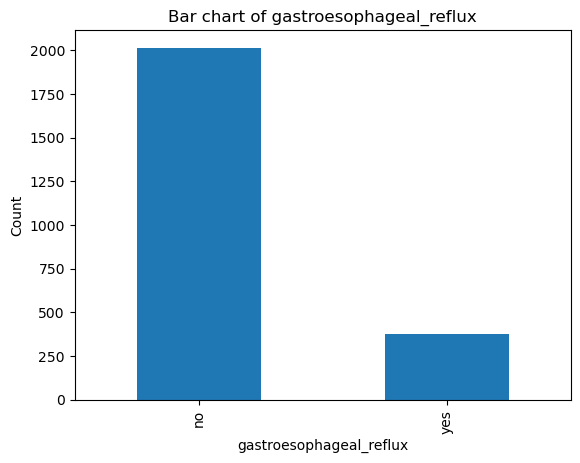

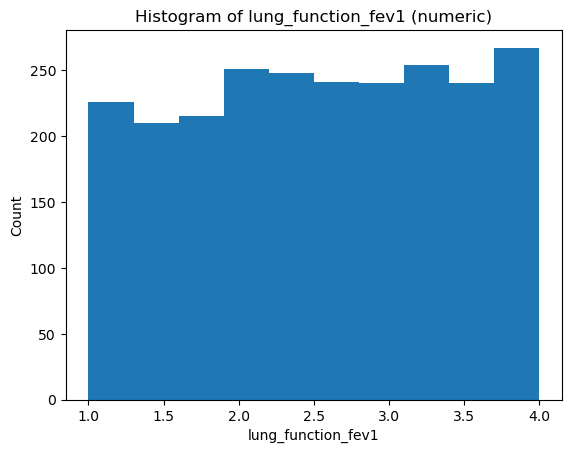

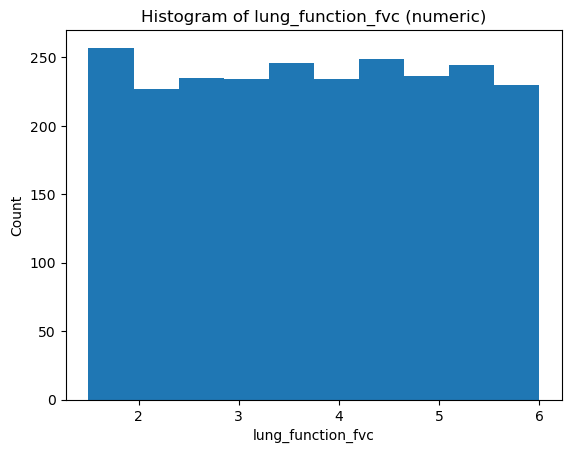

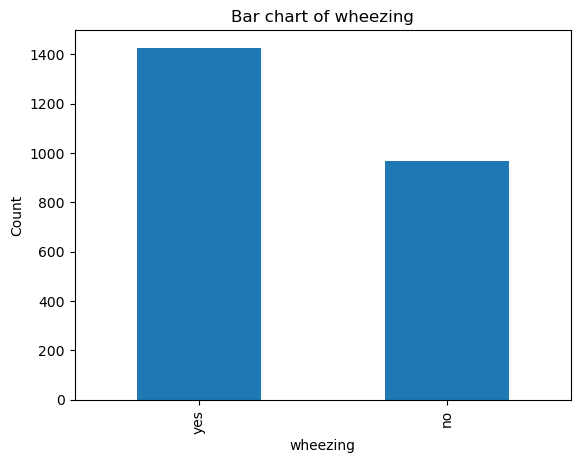

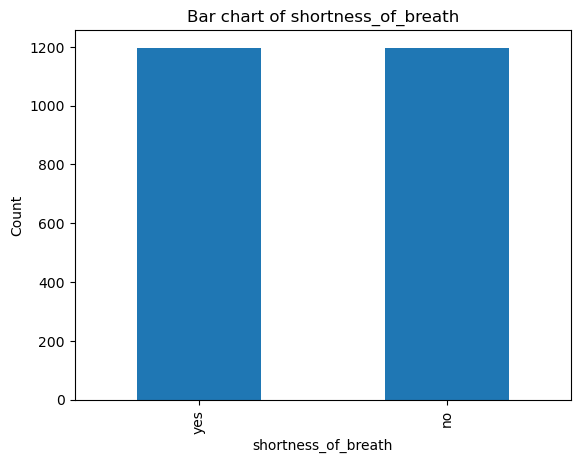

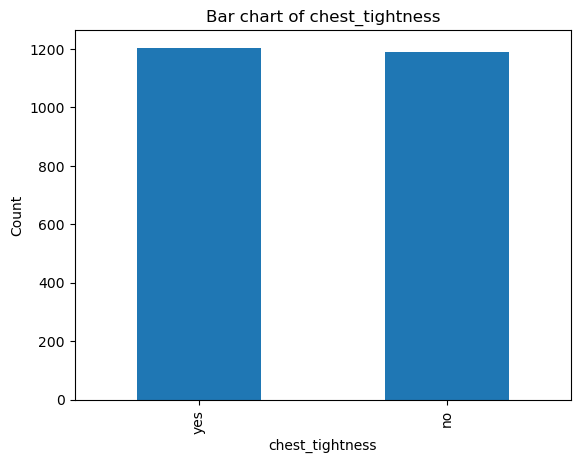

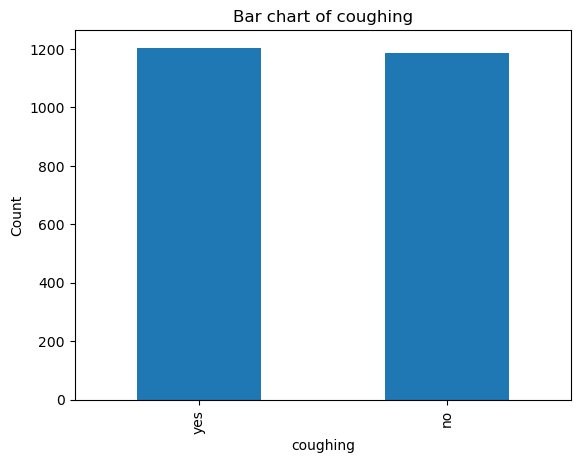

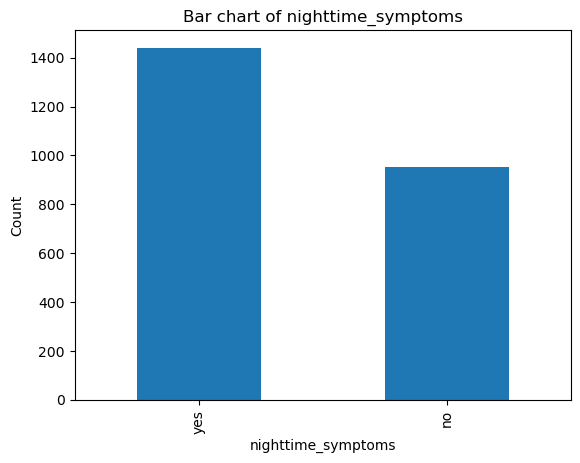

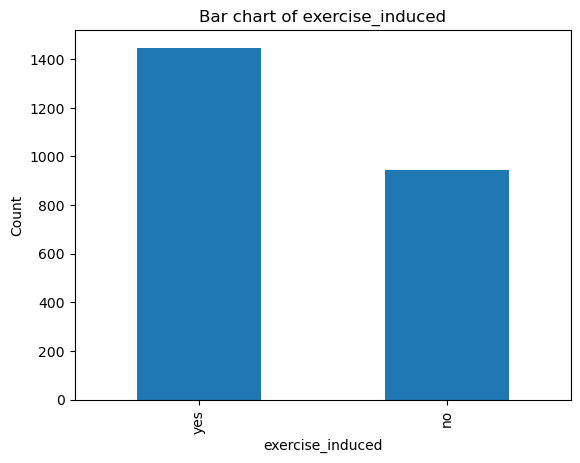

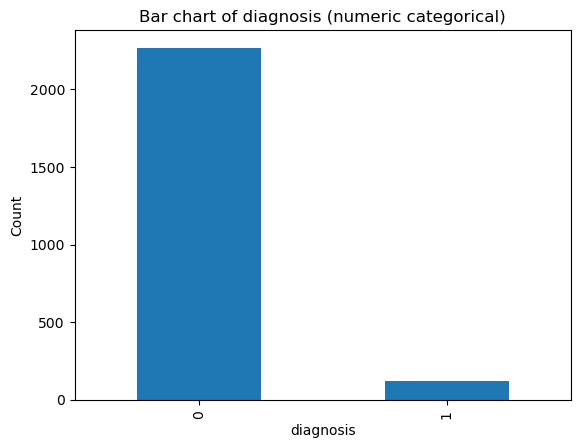

In [23]:
plot_all(asthma_vis.iloc[:, 1:])

Interestingly, numeric variables are quite evenly distributed. The sample is dominated by Caucasian respondents. Some binary variables are very unevenly distributred, in particular the outcome variable, `diagnosis`. 


In [43]:
asthma_an.diagnosis.value_counts()

diagnosis
0    2268
1     124
Name: count, dtype: int64

## Bivariate Visualization: intercorrelations

In [25]:
cors = asthma_an.corr()

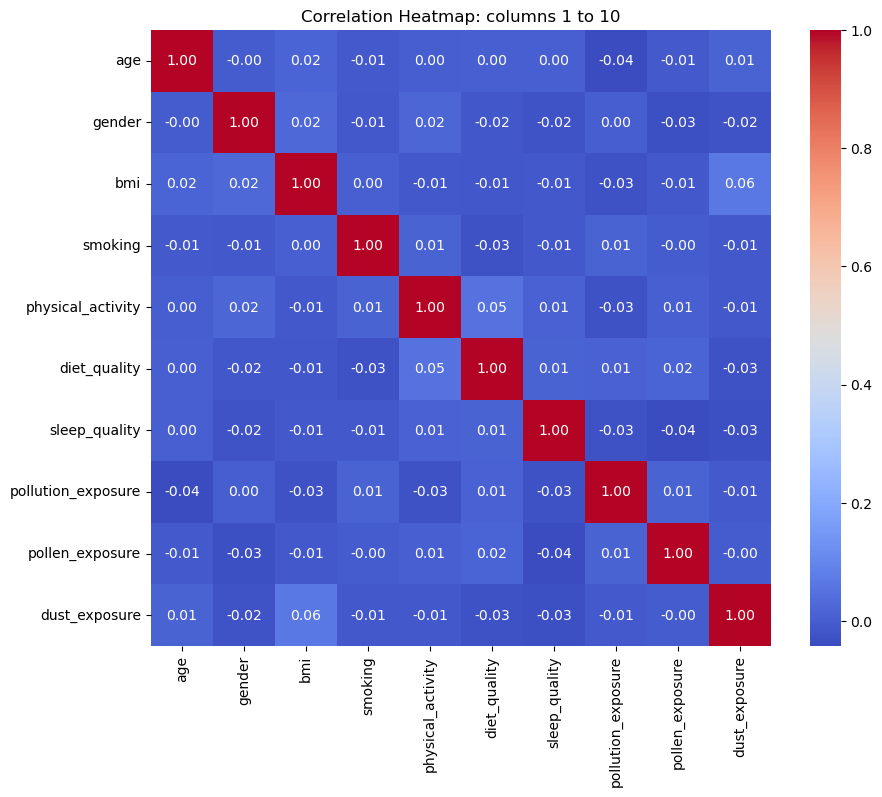

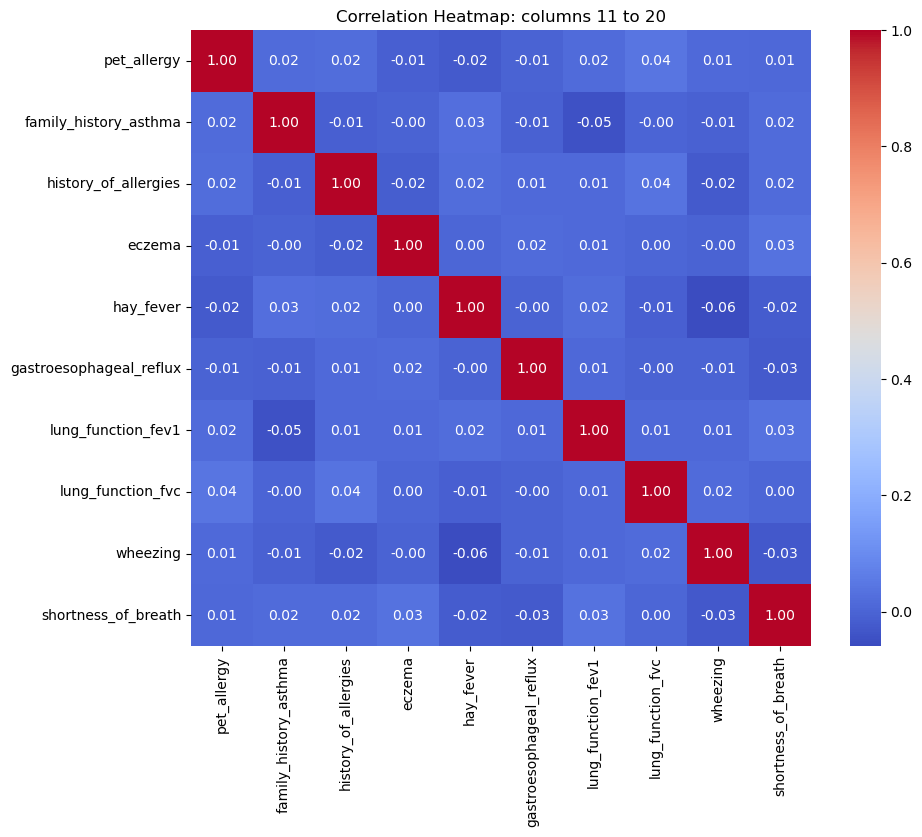

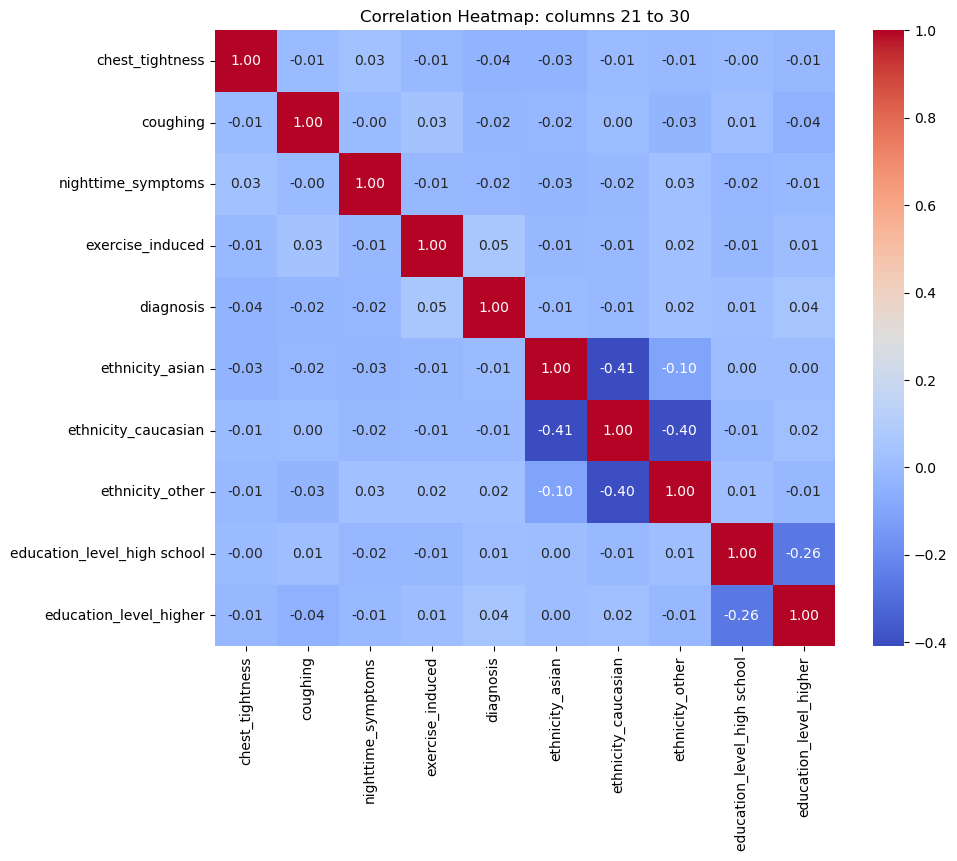

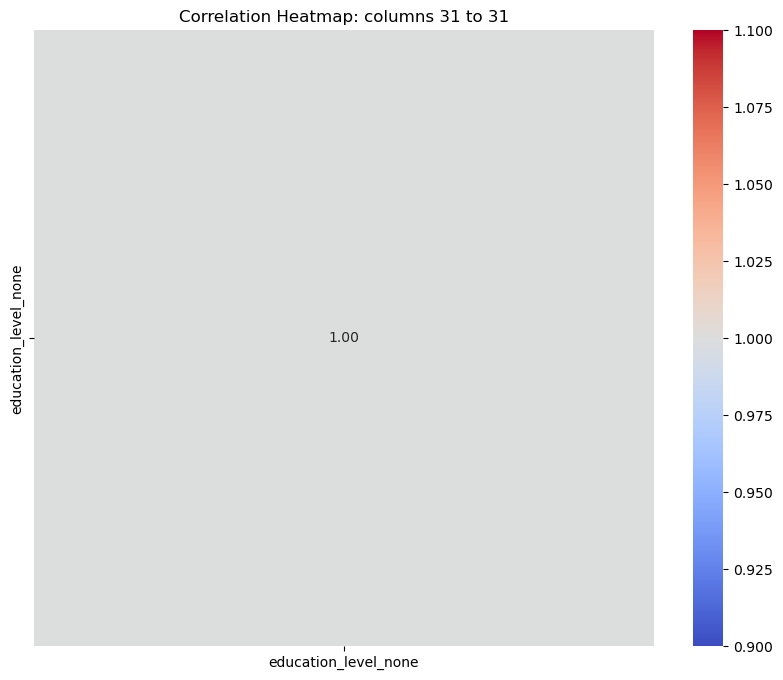

In [33]:
chunk_size = 10
columns = cors.columns.tolist()

for i in range(0, len(columns), chunk_size):
    cols_chunk = columns[i:i + chunk_size]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cors.loc[cols_chunk, cols_chunk], annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Correlation Heatmap: columns {i+1} to {i+len(cols_chunk)}")
    plt.show()

That is very interesting: all the variables (except the levels of the dummy coded variable) seem uncorrelated. 

In [35]:
def correlation_overview(df, threshold=0.3, figsize=(16, 12), cmap="coolwarm"):
    """
    Display correlations above a threshold and a heatmap.
    
    Parameters:
        df (pd.DataFrame): Input data
        threshold (float): Minimum absolute correlation to display in table
        figsize (tuple): Figure size for heatmap
        cmap (str): Colormap for heatmap
    """
    # 1. Compute correlation matrix
    corr_matrix = df.corr()
    
    # 2. Flatten and sort correlations, remove self-correlations
    corr_pairs = corr_matrix.unstack()
    corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
    corr_pairs = corr_pairs.abs().sort_values(ascending=False)
    
    # Filter by threshold
    corr_pairs_filtered = corr_pairs[corr_pairs >= threshold]
    
    # Remove duplicates (1-2 and 2-1)
    corr_pairs_filtered = corr_pairs_filtered[~corr_pairs_filtered.index.duplicated()]
    
    print("Correlations above threshold:")
    display(corr_pairs_filtered)
    
    # 3. Heatmap with upper triangle masked
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap)
    plt.title("Correlation Heatmap (upper triangle masked)")
    plt.show()


Correlations above threshold:


ethnicity_asian              ethnicity_caucasian            0.409042
ethnicity_caucasian          ethnicity_asian                0.409042
                             ethnicity_other                0.403090
ethnicity_other              ethnicity_caucasian            0.403090
education_level_none         education_level_high school    0.399628
education_level_high school  education_level_none           0.399628
                             education_level_higher         0.262078
education_level_higher       education_level_high school    0.262078
dtype: float64

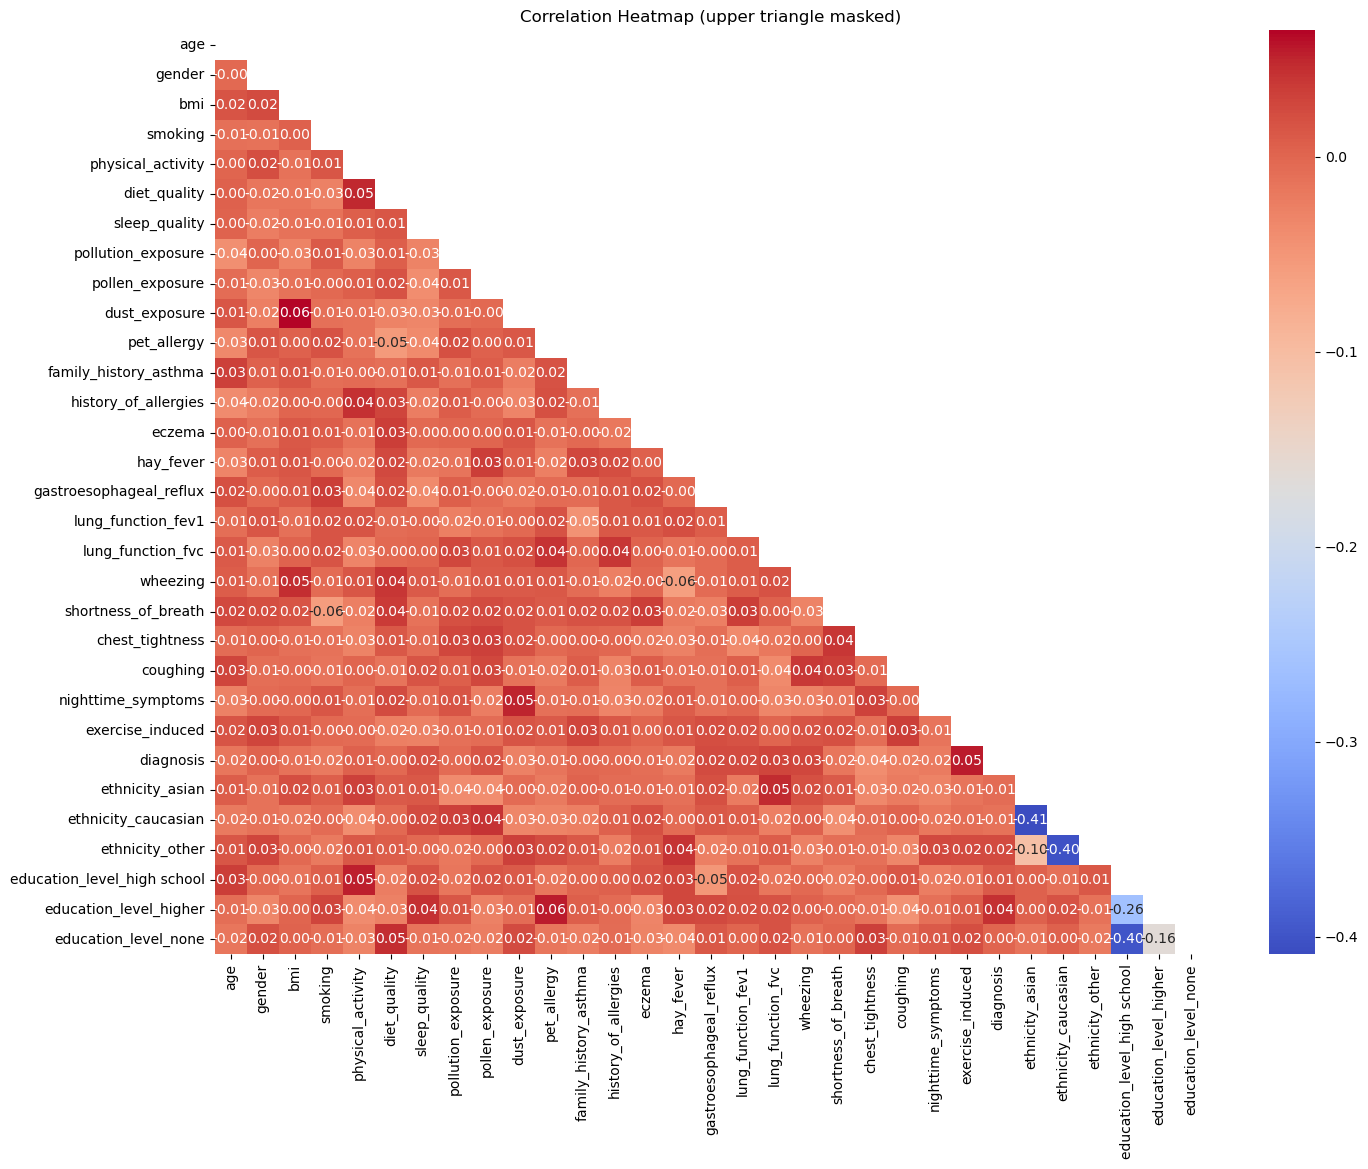

In [37]:
correlation_overview(asthma_an, threshold=0.2)

In [41]:
import pandas as pd

def target_correlations(df, target, threshold=None):
    """
    Compute correlation of all features with the target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        target (str): Name of the outcome variable
        threshold (float, optional): If set, only return correlations with abs(corr) >= threshold
    """
    # Ensure target exists
    if target not in df.columns:
        raise ValueError(f"Target '{target}' not found in DataFrame.")
    
    # Compute correlations with target
    corr_with_target = df.corr()[target].drop(target).sort_values(key=abs, ascending=False)
    
    # Apply threshold if specified
    if threshold is not None:
        corr_with_target = corr_with_target[abs(corr_with_target) >= threshold]
    
    return corr_with_target.sort_values()


In [42]:
target_correlations(df = asthma_an, target = "diagnosis")

chest_tightness               -0.039278
dust_exposure                 -0.025972
coughing                      -0.024193
nighttime_symptoms            -0.021965
smoking                       -0.019321
hay_fever                     -0.019141
shortness_of_breath           -0.015281
age                           -0.015111
pet_allergy                   -0.013078
bmi                           -0.012522
ethnicity_caucasian           -0.011398
eczema                        -0.008592
ethnicity_asian               -0.005584
pollution_exposure            -0.004535
diet_quality                  -0.003149
history_of_allergies          -0.001951
family_history_asthma         -0.001334
education_level_none           0.001041
gender                         0.003128
physical_activity              0.005066
education_level_high school    0.010182
pollen_exposure                0.015099
sleep_quality                  0.018022
ethnicity_other                0.022309
gastroesophageal_reflux        0.022770


Now this is very strange. Correlations vary between -.04 and .05, even for variables that inuitively should matter (e.g., family history of asthma)